# Compare different subgroup scaling results using our methodology vs. Sarkar's

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
#from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import lmfit 
#import import_ipynb
#import KEM_Rand

## Input from Data

In [13]:
# CHANGE FILEPATH HERE
data = pd.read_csv("empiricalAnalysis/CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("empiricalAnalysis/CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")


# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

# If True, will only read in data from MSAs (not Micropolitan SAs). If False, includes all data
ONLY_MSA = True

for _,ct in data.iterrows():
    msa = ct['msa']
    ct_id = ct["ct"]
    
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    
    # skip over entry if it's a Micro area and you've set the script to only read Metro (not Micro)
    if ONLY_MSA and not metro:
        continue
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)

In [14]:
e_pops = list(city_pops.values())
e_ctpops = list(fullpops.values())
e_incomes = list(income_lists.values())

In [15]:
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 16}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 16})


## Generate test distributions

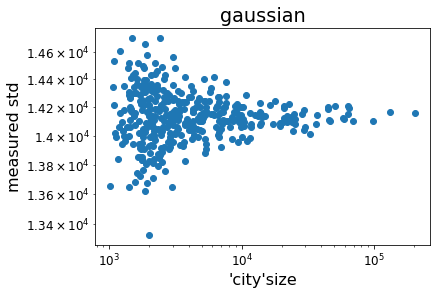

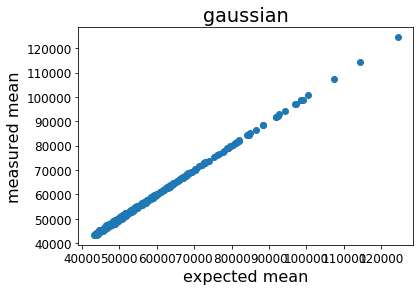

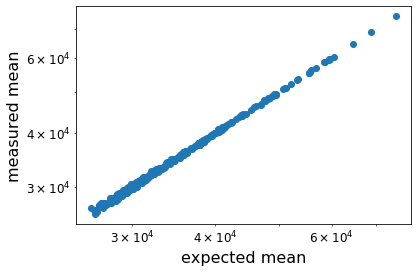

In [40]:
sorted_pops = sorted(e_pops)

# Gaussian with fixed mean
gaussian_model = []
E_mean = []
M_mean = []
E_std = []
M_std = []
sizes = []

def remove_negative(x):
    if x < 0.:
        return 0.
    else:
        return x 

for citysize in sorted_pops:
    n_samples = int(citysize/100)
    # mean scales with city size
    mean = 4300.*citysize**0.2
    # standard deviation is fixed across city size
    std = np.sqrt(2.*10**8)
#     std = np.sqrt(2.*10**8)*(1./(1000000**0.2))*citysize**0.2
    gaussian_samples = np.random.normal(mean,std,n_samples)
#     gaussian_samples = np.array([remove_negative(x) for x in gaussian_samples])
    E_mean.append(mean)
    M_mean.append(np.mean(gaussian_samples))
    E_std.append(std)
    M_std.append(np.std(gaussian_samples))
    sizes.append(n_samples)
    gaussian_model.append([citysize,gaussian_samples])
gaussian_model = np.array(gaussian_model)
np.save("Gaussian_test_model.npy",gaussian_model)



plt.figure()
# plt.scatter(E_mean,M_mean)
# plt.xlabel("expected mean")
# plt.ylabel("measured mean")
# plt.xlabel("expected std")
plt.xlabel("\'city\'size")
plt.ylabel("measured std")
plt.scatter(sizes,M_std)
plt.title("gaussian")
plt.yscale("log")
plt.xscale("log")
plt.show()
plt.close()

plt.figure()
plt.scatter(E_mean,M_mean)
plt.xlabel("expected mean")
plt.ylabel("measured mean")
# plt.xlabel("expected std")
# plt.xlabel("\'city\'size")
# plt.ylabel("measured skewness")
# plt.scatter(sizes,[scipy.stats.skew(x) for x in gaussian_model[:,1]])
plt.title("gaussian")
# plt.yscale("log")
# plt.xscale("log")
plt.show()
plt.close()



# Gamma with increasing mean, std, and skewness:
gamma_model = []

max_pop = np.max(e_pops)
min_pop = np.min(e_pops)
min_k = 1.5
max_k = 10.
max_mean = 75000.


E_mean = []
M_mean = []
sizes = []
for citysize in sorted_pops:
    n_samples = int(citysize/100)
    # k linearly decreases with city size (increases skewness) 
    # NOTE: Might want to make this a log-relationship to make the changes more significant
    k = -1.*(citysize-min_pop)**0.2*((max_k-min_k)/(max_pop-min_pop)**0.2) + max_k
    # theta scales with city size such that the mean follows the same scaling as empirical
    # Because mean = k*theta, theta is proportional also to k^-1
    theta = citysize**0.2*(max_mean/(max_pop**0.2))/k
#     print("size:",citysize)
#     print("Expected Mean = {}".format(theta*k))
    gamma_samples = np.random.gamma(k,theta,n_samples)
#     print("measured mean:",np.mean(gamma_samples))
    gamma_model.append([n_samples,gamma_samples])
    E_mean.append(theta*k)
    M_mean.append(np.mean(gamma_samples))
    sizes.append(n_samples)
gamma_model = np.array(gamma_model)
np.save("Gamma_test_model.npy",gamma_model)


plt.figure()
plt.scatter(E_mean,M_mean)
plt.xlabel("expected mean")
plt.ylabel("measured mean")
plt.title("Gamma")
plt.yscale("log")
plt.xscale("log")
plt.show()
plt.close()
    
# To show distributions 
test_model = gaussian_model 
show_dists = False
if show_dists:
    for pop,inc_dist in test_model:
        print(pop)
        plt.figure()
        plt.hist(inc_dist)
        plt.show()
        plt.close()

# Main Analysis: Methodology Comparison

method: sliding-windows
distribution: gaussian
0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


7


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


8


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


10


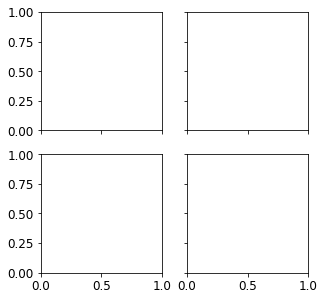

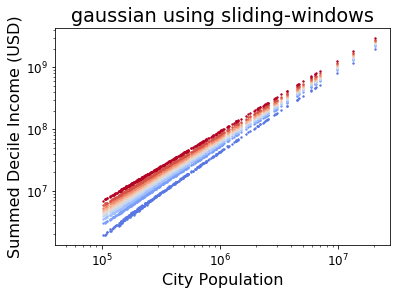

i_plot: 0
X: 0
y: 0
method: sliding-windows
distribution: gamma
0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


7
8


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


10


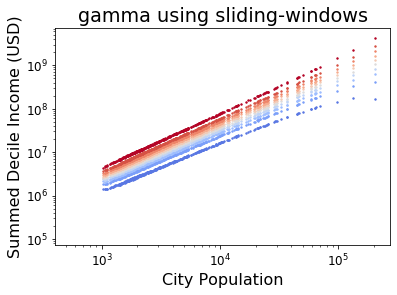

i_plot: 1
X: 1
y: 0
method: fixed-windows
distribution: gaussian
0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


7


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


8


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


10


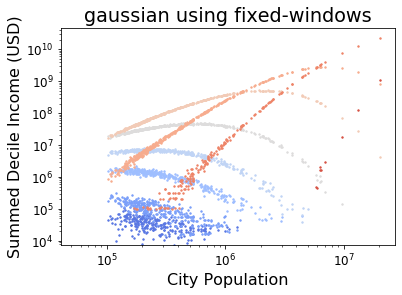

i_plot: 2
X: 0
y: 1
method: fixed-windows
distribution: gamma
0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


7


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


8


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


10


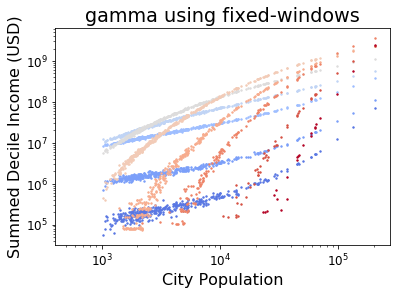

i_plot: 3
X: 1
y: 1


In [43]:
# switch variable for whether to produce scaling plots or plots of beta scaling exponents
to_show = "scaling" # OR "betas"

fixed_inc_windows = {
    1:(0,10000.),
    2:(10000.,15000.),
    3:(15000.,25000.),
    4:(25000.,35000.),
    5:(35000.,50000.),
    6:(50000.,75000.),
    7:(75000.,100000.),
    8:(100000.,150000.),
    9:(150000.,200000.),
    10:(200000.,np.inf)
}


size_factor = 0.8
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(6*size_factor,size_factor*6))
i_plot = -1

for method in ["sliding-windows","fixed-windows"]:
    for model in ["gaussian","gamma"]:#[
# for method in ["sliding-windows"]:
#     for model in ["empirical"]:#[
        print("method:",method)
        print("distribution:",model)
        if model=="empirical":
            pop_list = e_pops
            income_list = e_incomes
            ctpop_list = e_ctpops
        elif model=="gaussian":
            pop_list =  gaussian_model[:,0]
            income_list = gaussian_model[:,1]
            ctpop_list = [np.ones((len(income))) for income in income_list]
        elif model=="gamma":
            pop_list =  gamma_model[:,0]
            income_list = gamma_model[:,1]
            ctpop_list = [np.ones((len(income))) for income in income_list]
        
        i_plot +=1

        deciles = {}
        for i in range(1,11):
            deciles[i] = ([],[])
        results = {}
        full_incs = []
        # for each city:
        for incomes,pop,ctpops in zip(income_list,pop_list,ctpop_list):
            #split into deciles:
            full_inc = 0
            sum_pop = sum(ctpops)
            mean_income = np.mean(incomes)
            pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
            cumulative_pop = 0.
            current_decile = 1
            # summed population and income for current decile
            decile_pop = 0.
            decile_inc = 0.
            max_inc = np.max(incomes)
            min_inc = np.min(incomes)
            # sort by income
            incomes,ctpops = (list(t) for t in zip(*sorted(zip(incomes, ctpops))))
            
            # for each census tract within each city
            for ctpop, ctinc in zip(ctpops,incomes):
                cumulative_pop += ctpop
                decile_pop += ctpop
                decile_inc += ctinc*ctpop
                full_inc += ctinc*ctpop
                

                
                # for first one, fill in empty lower deciles
                if ctinc == min_inc:
                    if "sliding" in method:
                        cutoff = (cumulative_pop >= pop_cutoffs[(current_decile - 1)])
                    elif "fixed" in method:
                        cutoff = ((ctinc >= fixed_inc_windows[current_decile][1]) or (ctinc==max_inc))
                    
                    while cutoff:
                        deciles[current_decile][0].append(0)
                        deciles[current_decile][1].append(0)
                        current_decile += 1
                        if "sliding" in method:
                            cutoff = (cumulative_pop >= pop_cutoffs[(current_decile - 1)])
                        elif "fixed" in method:
                            cutoff = ((ctinc >= fixed_inc_windows[current_decile][1]) or (ctinc==max_inc))
                   
                if "sliding" in method:
                    cutoff = (cumulative_pop >= pop_cutoffs[(current_decile - 1)])
                elif "fixed" in method:
                    cutoff = ((ctinc >= fixed_inc_windows[current_decile][1]) or (ctinc==max_inc))
                    
                if cutoff:
                    current_decile += 1
#                     print("moving to decile {}".format(current_decile))
                    if "sliding" in method:
                        correction = (sum_pop/10.)/(decile_pop)
                        decile_inc *= correction 
                    # PER-PERSON
#                     decile_inc *= 1./decile_pop
#                     decile_inc = decile_inc - mean_income
                    
                    
                    
                    #store in deciles
                    deciles[(current_decile-1)][0].append(decile_inc)
                    deciles[(current_decile-1)][1].append(pop)
                    #reset
                    decile_pop = 0
                    decile_inc = 0
                # some model dists have zero incomes in some of the fixed windows. Insert zero into those
                if ctinc==max_inc and current_decile != 11:
                    if "fixed" in method:
                        while current_decile != 11:
                            deciles[current_decile][0].append(0)
                            deciles[current_decile][1].append(0)
                            current_decile += 1
                    elif "sliding" in method:
                        if current_decile != 10:
                            print("Unknown Error occuring!!! should only reach this point for final decile in sliding method")
                        # for rare case where the highest-income CT gets sorted into decile 9 before decile 10 gets any data sorted into it
                        # use just last CT for highest decile
                        correction = (sum_pop/10.)/(ctpop)
                        ctinc *= correction 

                        #store in deciles
                        deciles[10][0].append(ctinc)
                        deciles[10][1].append(pop)
                        


            sum_inc = np.sum(np.array(incomes)*np.array(ctpops))
            full_incs.append(full_inc)

        def standardModelFunc(x,y0,delta):
            return y0*(x**(1+delta))
        def standardLogResidual(params, x, true_data):
            model = standardModelFunc(x,params['y0'],params['delta'])
            return np.log(true_data)-np.log(model)

        def standardLogMod(x,logy0,delta):
            return logy0+x*(1+delta)

        
        def smartLog(x):
            if x <= 0:
                return 0.
            else:
                return np.log(x)

        fin = plt.figure()
#         ax_scaling = plt.gca()
        decileFits = {}
        decileModels = {}
        decileParams = {}

        mods = {}
        betas = []
        beta_ul = []
        beta_ll = []
        ds = []
        
#         plt.figure()
        cmap = plt.cm.get_cmap('coolwarm')
        for i in range(0,11):
    #         print(i)
            if i > 0:
                x = np.array(list(deciles[i][1]))
                y = np.array(list(deciles[i][0]))
                if to_show == "scaling":
                    plt.scatter(x[x.nonzero()],y[x.nonzero()],s=2,c=cmap(i/10.))
                logx = np.array([smartLog(a) for a in x])
                logy = np.array([smartLog(a) for a in y])
            else:
                y,x = full_incs,pop_list
                x = [a for a in x]
                logx = np.array([smartLog(a) for a in x])
                logy = np.array([smartLog(a) for a in y])


            mods[i] = lmfit.Model(standardLogMod)
            params = mods[i].make_params(logy0=10,delta=0)
            print(i)
            results[i] = mods[i].fit(logy,params,x=logx)
            if logy.nonzero()[0].size == 0:
                continue
            results[i].conf_interval()
            beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
            beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
            ds.append(i)
            betas.append(results[i].ci_out['delta'][3][1])
            fity = np.exp(np.array(results[i].ci_out['logy0'][3][1],dtype=np.float128))*x**(1+results[i].ci_out['delta'][3][1])
            
        if to_show == "scaling":
#             plt.xlim((0.9*np.min(deciles[10][1]), 1.1*np.max(deciles[10][1])))
            plt.yscale("log")
            plt.xscale("log")
#             plt.ylim((0.9*np.min(deciles[1][0]), 1.1*np.max(deciles[10][0])))
            plt.xlabel("City Population")
#             plt.ylabel("Per-Person Income (USD)")
            plt.ylabel("Summed Decile Income (USD)")
            ttl = model + " using " + method
            plt.title(ttl)


    #         # plt.legend()
            plt.show()
            plt.close()

        # FOR SWITCHING X AND Y IN BETA PLOT
    #     plt.plot(np.zeros(len(betas)),ds,'--')
    #     for i in range(0,10):
    #         c = cmap((i+1)/10.)
    #         plt.errorbar(betas[i],ds[i],xerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
    #     plt.ylabel("Decile (lowest to highest incomes)")
    #     plt.xlabel("$\\beta - 1$")

        #TODO: Double check this
        x = i_plot%2
        y = i_plot//2
        print("i_plot:",i_plot)
        print("X:",x)
        print("y:",y)
        
        if to_show == "betas":
            ax[y,x].plot(ds,np.zeros(len(betas)),'--')
#             ax[y,x].plot(ds,-1.*np.ones(len(betas)),'--')
            for i in range(0,11):
                c = cmap(i/10.)
                if i == 0:
                    if i_plot == 0:
                        t_plot = ax[y,x].errorbar(0,betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)[0]
                    else:
                        ax[y,x].errorbar(0,betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)
                else:
                    # skip if all zeros:
                    if np.array(betas).nonzero()[0].size == 0:
                        continue
                        print("continuing")
                    try:
                        ax[y,x].errorbar(ds[i],betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
                    except IndexError:
                        print("ignoring error")
#                         set_trace()


#         def linear(x,m,b):
#             return m*x + b
#         mod_bd = lmfit.Model(linear)
#         params = mod_bd.make_params(m=0,b=0)
#         results_bd = mod_bd.fit(betas[1:],params,x=[a/10. for a in ds[1:]])
#         results_bd.conf_interval()
#         print("CI for beta vs. decile: [{},{}]".format(results_bd.ci_out['m'][1][1],results_bd.ci_out['m'][5][1]))




if to_show == "betas":


    # fig.text(0.5, 0.00, 'Decile (lowest to highest incomes)', ha='center')
    # fig.text(0.00, 0.5, '$\\beta - 1$', va='center', rotation='vertical')

    # # outer model labels
    fig.text(.2, 0.9, 'Gaussian', va='center',style='italic')
    fig.text(.6, .9, 'Gamma', va='center',style='italic')
    fig.text(.9, 0.3, 'Sarkar', va='center', rotation=-90,style='italic')
    fig.text(.9, 0.7, 'SFI', va='center', rotation=-90,style='italic')
    plt.xlabel("Decile (lowest to highest incomes)")
    plt.ylabel("$\\beta - 1$")
    # fig.suptitle("Methodology Comparison")
    # # fig.legend([t_plot],["Total"],loc='upper left')#,bbox_to_anchor=(1., 1.))
    plt.show()
    plt.close()

## Simplified version of decile scaling analysis - to cross-check results above

Text(0, 0.5, 'Per-Capita Decile Income (USD)')

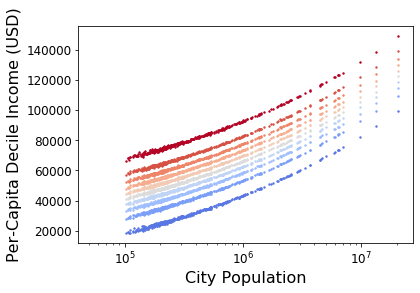

In [29]:
pop_list =  gaussian_model[:,0]
income_list = gaussian_model[:,1]
# list of summed incomes for respective decile
decile_sum_incs = {
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
    10:[]
}

for (incomes,citypop) in zip(income_list, pop_list):
    incomes = sorted(incomes)
    n_incomes = len(incomes)
    min_index = 0
#     print("new city!")
    for i in range(1,11):
        max_index = int(n_incomes*i/10.)
#         print("decile pop ~ ",(max_index-min_index))
        decile_sum_incs[i].append(np.sum(np.array(incomes[min_index:max_index])/(max_index-min_index)))
        min_index=max_index
        
cmap = plt.cm.get_cmap('coolwarm')
for i in range(1,11): 
    plt.scatter(pop_list,decile_sum_incs[i],s=2,c=cmap([i/10.]))
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("City Population")
plt.ylabel("Per-Capita Decile Income (USD)")
# plt.ylabel("Summed Decile Income (USD)")